# Praca domowa nr 1 Warsztaty Badawcze

#### Filip Szympliński, 313513

## Wczytanie pakietów i zbiorów danych

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from tqdm.notebook import tqdm

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, recall_score, precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score, median_absolute_error
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost as xgb

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

In [50]:
planes_train = pd.read_csv("./data/airline_passenger_satisfaction/train.csv")
planes_train = planes_train.drop(labels=["Unnamed: 0", "id"], axis=1)

In [51]:
cars = pd.read_csv("./data/car_prices_poland/Car_Prices_Poland.csv")
cars = cars.drop(labels="Unnamed: 0", axis=1)

# Zbiór danych o samolotach - zadanie klasyfikacji według zmiennej `satisfaction`

In [52]:
planes_train.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

W kolumnie `Arrival Delay in Minutes` jest 310 braków danych. Zastąpimy je medianą wartości z tej kolumny

In [53]:
col_name = "Arrival Delay in Minutes"
planes_train.loc[planes_train[col_name].isna(),col_name] = planes_train[col_name].mean()

## Szybkie spojrzenie na dane

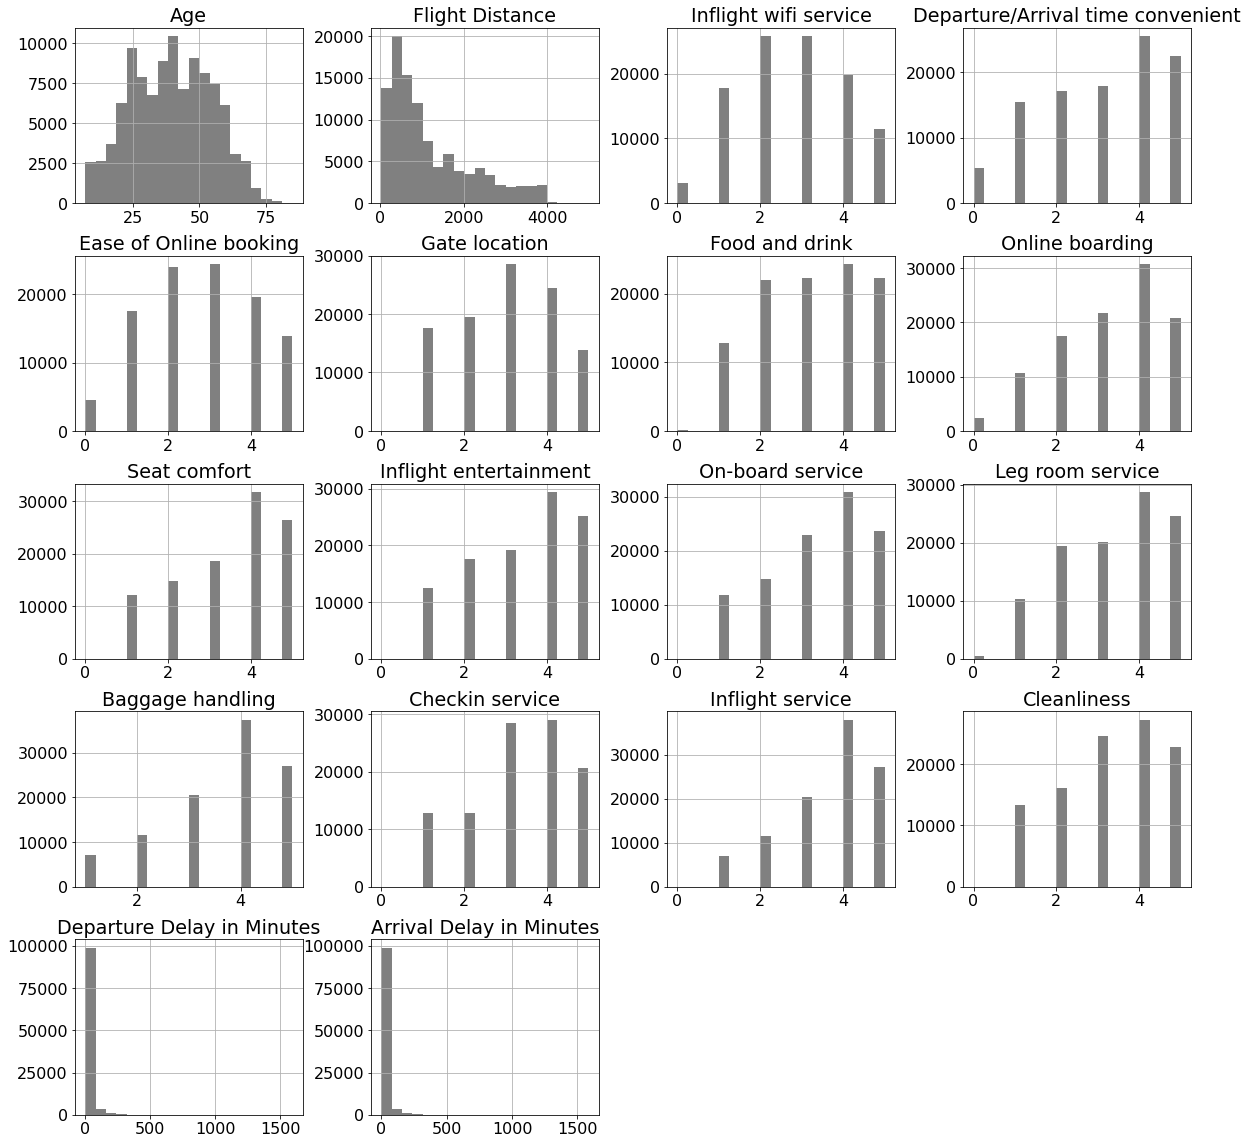

In [55]:
planes_train.hist(bins = 20, figsize=(20, 20), color="gray")
plt.show()

Z powyższych rozkładów raczej nie wyciągniemy bardzo interesujących informacji. Jedyne co należałoby rozpatrzeć, to usunięcie wartości bardzo odstających w zmiennych `Departure Delay in Minutes` oraz `Arrival Delay in Minutes` tak zwanych far out, czyli wartości większych od Q1-3*IQR. Jeśli takowych wartości będzie bardzo mało względem całości, można rozważyć usunięcie, bowiem moga to być pojedyncze sytuacje spowodowane przykładowo nagłą awarią.

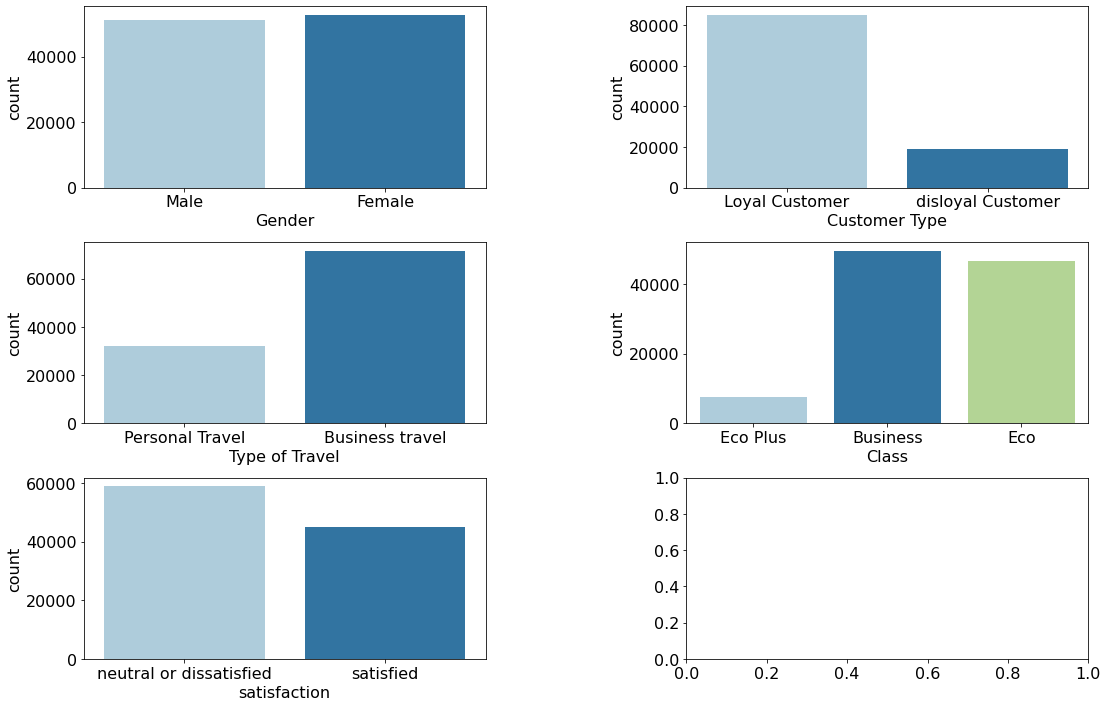

In [56]:
discrete_col_names = planes_train.select_dtypes(include = 'object').columns
fig, axes = plt.subplots(3,2, figsize = (18, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.5)
sns.set_palette("Paired")

for col, ax in zip(discrete_col_names, axes.flatten()):
    sns.countplot(x=col, data=planes_train, ax=ax)

Klasy "neutral or dissatisfied" oraz "staisfied" zmiennej `satisfaction` mają lekkie niezbalansowanie, ale nie na tyle duże aby było  

## Preprocessing

### Usunięcie w zmiennych `Departure Delay in Minutes` oraz `Arrival Delay in Minutes` wartości far out - do przemyślenia jeszcze

#### Zmienna `Departure Delay in Minutes`

In [57]:
var_name = "Departure Delay in Minutes"

In [58]:
Q1 = planes_train[var_name].quantile(0.25)
Q2 = planes_train[var_name].quantile(0.5)
Q3 = planes_train[var_name].quantile(0.75)
IQR = Q3 - Q1

In [59]:
dep_delay_far_out = planes_train.loc[~planes_train[var_name].between(Q1-3*IQR, Q3+3*IQR, inclusive = True)]

In [60]:
dep_delay_far_out_index = set(dep_delay_far_out.index)

In [61]:
dep_delay_far_out[var_name].describe()

count    9318.000000
mean      107.950955
std        75.070549
min        49.000000
25%        62.000000
50%        84.000000
75%       126.000000
max      1592.000000
Name: Departure Delay in Minutes, dtype: float64

In [62]:
dep_delay_far_out.shape[0]/planes_train.shape[0]

0.08967893440098552

Te wartości odstające far out stanowią prawie 9% całości zbioru treningowego, więc nie należałoby tak poprostu ich usunąć.

#### Zmienna `Arrival Delay in Minutes`

In [63]:
var_name = "Arrival Delay in Minutes"

In [64]:
Q1 = planes_train[var_name].quantile(0.25)
Q2 = planes_train[var_name].quantile(0.5)
Q3 = planes_train[var_name].quantile(0.75)
IQR = Q3 - Q1

In [65]:
arr_delay_far_out = planes_train.loc[~planes_train[var_name].between(Q1-3*IQR, Q3+3*IQR, inclusive = True)]

In [66]:
arr_delay_far_out_index = set(arr_delay_far_out.index)

In [67]:
dep_delay_far_out[var_name].describe()

count    9318.000000
mean      105.752389
std        78.113877
min         9.000000
25%        58.000000
50%        83.000000
75%       128.000000
max      1584.000000
Name: Arrival Delay in Minutes, dtype: float64

In [68]:
arr_delay_far_out.shape[0]/planes_train.shape[0]

0.08318255312596243

Te wartości odstające far out stanowią prawie 9% całości zbioru treningowego, więc nie należałoby tak poprostu ich usunąć.

Ze względu że wartości bardzo odstających od jest stosunkowo dużo dla obu zmiennych, to nie będa one usuwane, gdyż mogą zawierać istotne dane dla naszego modelu.

### Kodowanie zmiennych

In [69]:
planes_train.loc[planes_train["satisfaction"]=="satisfied", "satisfaction"] = 1
planes_train.loc[planes_train["satisfaction"]=="neutral or dissatisfied", "satisfaction"] = 0

#### One hot

In [70]:
col_names_encode = ["Gender", "Customer Type", "Type of Travel", "Class"]
encoded = pd.get_dummies(planes_train[col_names_encode].astype(str))
encoded = encoded.drop(["Gender_Female","Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Eco"], axis = 1)
planes_train_one_hot = planes_train.drop(col_names_encode, axis=1)
planes_train_one_hot = pd.concat([planes_train_one_hot, encoded], axis = 1)

#### Manual encoding

In [71]:
planes_train['Gender'] = (planes_train['Gender'] == 'Female')*1
planes_train['Customer Type'] = (planes_train['Customer Type'] == 'Loyal Customer')*1
planes_train['Type of Travel'] = (planes_train['Type of Travel'] == 'Personal Travel')*1
planes_train.loc[planes_train["Class"]=="Eco", "Class"] = 0
planes_train.loc[planes_train["Class"]=="Eco Plus", "Class"] = 1
planes_train.loc[planes_train["Class"]=="Business", "Class"] = 2

## Podział zbioru

In [72]:
y_oh = planes_train_one_hot['satisfaction']
y_oh = y_oh.astype('int')
X_oh = planes_train_one_hot.drop("satisfaction", axis = 1)
X_oh_train, X_oh_val, y_oh_train, y_oh_val = train_test_split(X_oh, y_oh, random_state=420, test_size=0.125)

In [73]:
y = planes_train['satisfaction']
y = y.astype('int')
X = planes_train.drop("satisfaction", axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=420, test_size=0.125)

In [74]:
X_train.shape

(90916, 22)

In [75]:
X_val.shape

(12988, 22)

## Zabawa z klasyfikatorami

In [76]:
def show_model_metrics(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)
    print(f"F1 score: {f1_score(y_val, y_pred, average=None)}")
    print(f"Precision score: {precision_score(y_val, y_pred, average=None)}")
    print(f"Recall score: {recall_score(y_val, y_pred, average=None)}")
    print(f"Accuracy score: {accuracy_score(y_val, y_pred)}")
    print(f"ROC AUC score: {roc_auc_score(y_val, y_pred, average=None)}")

In [77]:
def gini_roc(y_test, y_pred_proba, tytul):
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    plt.plot(fpr,tpr)
    plt.title(tytul)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    roc_auc = metrics.auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    return gini

In [78]:
def gini_train_val(model, X_val, y_val):
    
    y_pred_proba = model.predict_proba(X_val)[::,1]
    gini_val = gini_roc(y_val, y_pred_proba, "Roc Curve for Validation Sample")
    print(f"gini_val: {gini_val}")

### Random Forest

In [335]:
rf_oh = RandomForestClassifier(random_state=2022, n_jobs=-1)
rf_oh.fit(X_oh_train, y_oh_train)

RandomForestClassifier(n_jobs=-1, random_state=2022)

In [336]:
rf = RandomForestClassifier(random_state=2022, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=2022)

Tworzenie dwóch modeli w zależności od sposobu kodowania nie było wymagane, ale byłem zbyt bardzo ciekaw czy dla tych danych ma to jakiekolwiek większe znaczenie, ponieważ podobno dla pewnych przypadków może występować różnica w osiągach.

In [337]:
show_model_metrics(rf_oh, X_oh_val, y_oh_val)

F1 score: [0.96822204 0.95714286]
Precision score: [0.95896414 0.96976915]
Recall score: [0.97766044 0.94484113]
Accuracy score: 0.9635047736372035
ROC AUC score: 0.9612507834181304


In [338]:
show_model_metrics(rf, X_val, y_val)

F1 score: [0.96667784 0.95506735]
Precision score: [0.95749768 0.96757648]
Recall score: [0.97603574 0.94287754]
Accuracy score: 0.9617339082229751
ROC AUC score: 0.959456643516256


In [347]:
cross_val_score(rf_oh, X_oh_train, y_oh_train, cv=5)

array([0.9616696 , 0.95990761, 0.96221746, 0.96199747, 0.96040257])

In [346]:
cross_val_score(rf, X_train, y_train, cv=5)

array([0.96177959, 0.96144751, 0.96232745, 0.96249244, 0.96023758])

Jak widać w tym przypadku zmiana sposobu kodowania zmiennych nie wpływa znacząco na osiągane wyniki przez modele. Użycie kodowania one hot Daje nawet trochę lepsze wyniki.

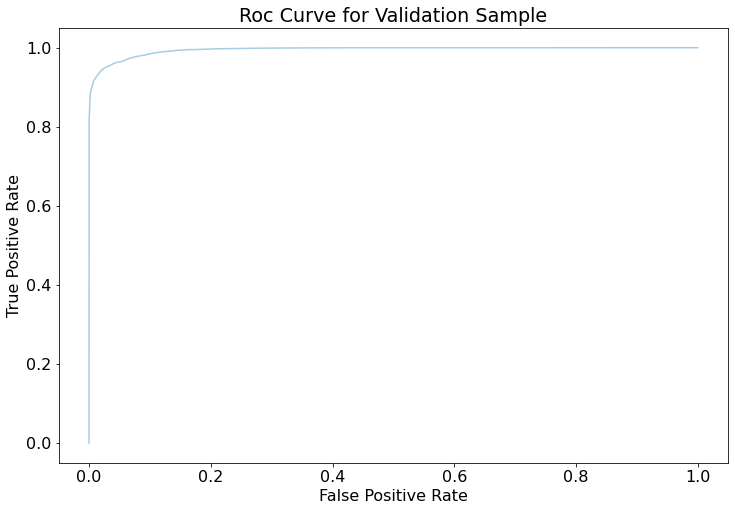

gini_val: 0.9890843498796849


In [339]:
gini_train_val(rf_oh, X_oh_val, y_oh_val)

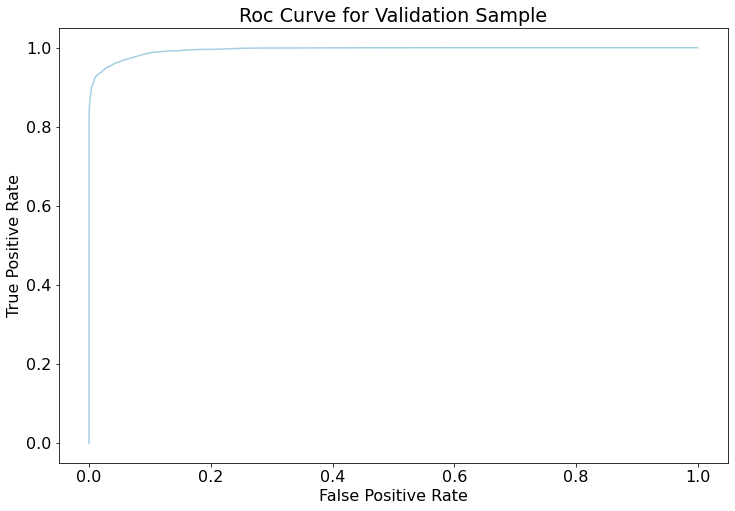

gini_val: 0.9892405259697492


In [340]:
gini_train_val(rf, X_val, y_val)

Obie krzywe ROC są bardzo podobne i nie można nic szczególnego powiedzieć o jakiś różnicach między modelami. Oba dają bardzo dobre wyniki dla różnych metryk.

Spójrzmy teraz jak będą się zmieniać wyniki dla modelu RandomForest używającego kodowania one hot (żeby nie powtarzać tego samego dla drugiego sposobu modelowania, bo są bardzo podobne) dla różnych parametrów.

In [348]:
rf1 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=500,
                             max_depth=20, criterion="entropy")
rf1.fit(X_oh_train, y_oh_train)
show_model_metrics(rf1, X_oh_val, y_oh_val)
cross_val_score(rf1, X_oh_train, y_oh_train, cv=5)

F1 score: [0.96830396 0.95720619]
Precision score: [0.95860422 0.97046414]
Recall score: [0.978202   0.94430561]
Accuracy score: 0.9635817677856483
ROC AUC score: 0.9612538044659884


array([0.9616696 , 0.96089754, 0.96205247, 0.96342738, 0.96100753])

Wyniki nie są znacznie odmienne od domyślnych wartości hiperparametrów. Random_state=2022 będzie ustawiony ręcznie dla powtarzalności wyników, natomist n_jobs=-1 w celu maksymalnego przyspieszenia obliczeń.

In [349]:
rf2 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=500,
                             max_depth=5, criterion="entropy")
rf2.fit(X_oh_train, y_oh_train)
show_model_metrics(rf2, X_oh_val, y_oh_val)
cross_val_score(rf2, X_oh_train, y_oh_train, cv=5)

F1 score: [0.93107133 0.90621592]
Precision score: [0.91879779 0.92299148]
Recall score: [0.94367723 0.89003927]
Accuracy score: 0.9205420388050508
ROC AUC score: 0.9168582494376258


array([0.9200396 , 0.92102513, 0.9169554 , 0.91882528, 0.91816532])

Zmiana max_depth na 5 powoduje delikatne pogorszenie osiągów.

In [351]:
rf3 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=100,
                             max_depth=5, criterion="entropy")
rf3.fit(X_oh_train, y_oh_train)
show_model_metrics(rf3, X_oh_val, y_oh_val)
cross_val_score(rf3, X_oh_train, y_oh_train, cv=5)

F1 score: [0.93003731 0.90426696]
Precision score: [0.91563894 0.92415207]
Recall score: [0.94489575 0.88521956]
Accuracy score: 0.9191561441330459
ROC AUC score: 0.9150576565775267


array([0.9200396 , 0.92058516, 0.91811032, 0.91822032, 0.91745037])

Przy zmianie n_estimators na 100 przy zachowaniu reszty parametrów tak jak jeden przykład powyżej nie powoduje zauważalnych zmian w wydajnośći.

---

In [356]:
rf4 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=25,
                             max_depth=200, criterion="entropy")
rf4.fit(X_oh_train, y_oh_train)
show_model_metrics(rf4, X_oh_val, y_oh_val)
cross_val_score(rf4, X_oh_train, y_oh_train, cv=5)

F1 score: [0.96469325 0.95251851]
Precision score: [0.95660277 0.96347699]
Recall score: [0.97292174 0.9418065 ]
Accuracy score: 0.9595010779180783
ROC AUC score: 0.9573641207595485


array([0.95732512, 0.95781774, 0.95990761, 0.96095254, 0.95737777])

Nie można w tym przypadku powiedzieć raczej nic ciekawego.

----

In [367]:
rf5 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=15,
                             criterion="gini", min_samples_split=10000)
rf5.fit(X_oh_train, y_oh_train)
show_model_metrics(rf5, X_oh_val, y_oh_val)
cross_val_score(rf5, X_oh_train, y_oh_train, cv=5)

F1 score: [0.90245539 0.86865402]
Precision score: [0.89441489 0.87929773]
Recall score: [0.91064175 0.85826491]
Accuracy score: 0.8880505081613798
ROC AUC score: 0.8844533300309654


array([0.8841839 , 0.87785294, 0.88500247, 0.88500247, 0.87988781])

In [369]:
rf6 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=15,
                             criterion="gini", min_samples_split=1000)
rf6.fit(X_oh_train, y_oh_train)
show_model_metrics(rf6, X_oh_val, y_oh_val)
cross_val_score(rf6, X_oh_train, y_oh_train, cv=5)

F1 score: [0.94097011 0.92154577]
Precision score: [0.93774371 0.92577914]
Recall score: [0.94421879 0.91735095]
Accuracy score: 0.9326301201108715
ROC AUC score: 0.9307848692002285


array([0.93186318, 0.93114448, 0.93180443, 0.93334433, 0.93141946])

Zwiększenie hipeparametru min_smaples_split do wartości 1000 dlaje podobne wyniki, jak zmiana maksymalnej wysokości dzrew do 5. Zapewne wynika to z tego, że minimalna ilość próbek potrzebna do podziału jeat mocno skorelowana z maksymalną wysokością drzewa (odwrotnie proporcjonalnie). Dopiero zmiana parametru min_smaples_split na 10000 powoduję znaczne pogorszenie wyników.

---

Zobaczmy teraz jak się zmieniają osiągi dla bazowych hiperparametrów poza criterion zmienionym z bazowego gini na entropy.

In [353]:
rf7 = RandomForestClassifier(random_state=2022, n_jobs=-1, criterion="entropy")
rf7.fit(X_oh_train, y_oh_train)
show_model_metrics(rf7, X_oh_val, y_oh_val)
cross_val_score(rf7, X_oh_train, y_oh_train, cv=5)

F1 score: [0.96765553 0.95626189]
Precision score: [0.95733404 0.97040985]
Recall score: [0.978202   0.94252053]
Accuracy score: 0.9628118263012011
ROC AUC score: 0.9603612660868381


array([0.96238451, 0.96188748, 0.96216246, 0.9630424 , 0.96056756])

W porównaniu do modelu `rf_oh` (bazowe hiperparametry) poszczególne metryki wypadły troszeczkę gorzej, natomiast widać nieco lepsze wyniki przy kroswalidacji, co może sugerować że dla tych danych użycie entropi jako kryterium podziału przy budowaniu drzew polepsza uogólnienie modelu.

---

In [373]:
rf8 = RandomForestClassifier(random_state=2022, n_jobs=-1,n_estimators=10,
                             max_depth=2, criterion="entropy")
rf8.fit(X_oh_train, y_oh_train)
show_model_metrics(rf8, X_oh_val, y_oh_val)
cross_val_score(rf8, X_oh_train, y_oh_train, cv=5)

F1 score: [0.8939854  0.84366962]
Precision score: [0.85493636 0.90459653]
Recall score: [0.93677227 0.79043199]
Accuracy score: 0.8736526024022174
ROC AUC score: 0.8636021302206004


array([0.87681478, 0.87009844, 0.87284826, 0.87592806, 0.87350822])

#### Wnioski odnośnie RandomForestClassifier

Jak widać z powyższych przykładów dzrewa losowe są dość mocno odporne na zmianę hiperparametrów. Wynika to zapewne z losowości powstających drzew. Dopiero drastyczna zmiana pewnych parametrów na bardzo wysokie bądź niskie powoduje pogorszenie wyników.

### XGBoost

Uwaga odnośnie hiperparametrów. Pewne z nich są stałe między innymi w celach powtarzalności, czy dla wygody.

In [81]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
X_train = X_train.astype('int')
X_val = X_val.astype('int')

Trzeba było zmienić typy zmiennych, aby działał XGBoost.

In [390]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, seed=2022, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)
show_model_metrics(xgb_clf, X_val, y_val)
cross_val_score(xgb_clf, X_train, y_train, cv=5)

F1 score: [0.96767256 0.95665495]
Precision score: [0.96076338 0.96596906]
Recall score: [0.97468183 0.94751874]
Accuracy score: 0.9629658145980905
ROC AUC score: 0.9611002868980393


array([0.96227453, 0.96117252, 0.96447231, 0.9630424 , 0.96271242])

Predykcyjność jest wysoka i porównywalna z lasem drzew losowych. Zbadajmy jak się będzie zmieniała predykcyjność dla innych wartości hiperparametrów niż domyślne.

---

In [82]:
xgb_clf1 = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, seed=2022, use_label_encoder=False,
                           n_estimators=20)
xgb_clf1.fit(X_train, y_train)
show_model_metrics(xgb_clf1, X_val, y_val)
cross_val_score(xgb_clf1, X_train, y_train, cv=5)

F1 score: [0.96068055 0.9468634 ]
Precision score: [0.95068275 0.96051423]
Recall score: [0.97089087 0.93359514]
Accuracy score: 0.9548044348629504
ROC AUC score: 0.9522430096094457


array([0.95545535, 0.95495793, 0.9553979 , 0.95743277, 0.95627784])

In [83]:
xgb_clf2 = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, seed=2022, use_label_encoder=False,
                           n_estimators=300)
xgb_clf2.fit(X_train, y_train)
show_model_metrics(xgb_clf2, X_val, y_val)
cross_val_score(xgb_clf2, X_train, y_train, cv=5)

F1 score: [0.96613935 0.95477025]
Precision score: [0.96077119 0.96194963]
Recall score: [0.97156783 0.94769725]
Accuracy score: 0.9612719433323067
ROC AUC score: 0.9596325410067369


array([0.96051474, 0.95930265, 0.96254743, 0.96243744, 0.95985261])

W obu powyższych przypadkach predykcyjność jest niższa w porównaniu do domyślnej wartości parametru `n_estimators`, co oznacz że optimum zapewne się znajduje fdzieś pomiędzy wartością 20 a 300. Mimo tego faktu predykcyjność nadal jest na wysokim poziomie.

---

In [84]:
xgb_clf3 = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, seed=2022, use_label_encoder=False,
                           max_depth=4)
xgb_clf3.fit(X_train, y_train)
show_model_metrics(xgb_clf3, X_val, y_val)
cross_val_score(xgb_clf3, X_train, y_train, cv=5)

F1 score: [0.96653676 0.95511087]
Precision score: [0.95944504 0.96467589]
Recall score: [0.97373409 0.94573367]
Accuracy score: 0.9616569140745304
ROC AUC score: 0.9597338790360838


array([0.95979982, 0.9599626 , 0.96216246, 0.96194247, 0.95902766])

In [85]:
xgb_clf3 = xgb.XGBClassifier(objective="binary:logistic", verbosity=0, seed=2022, use_label_encoder=False,
                           max_depth=40)
xgb_clf3.fit(X_train, y_train)
show_model_metrics(xgb_clf3, X_val, y_val)
cross_val_score(xgb_clf3, X_train, y_train, cv=5)

F1 score: [0.96867016 0.95802558]
Precision score: [0.96207265 0.96690909]
Recall score: [0.97535879 0.94930382]
Accuracy score: 0.9641207268247614
ROC AUC score: 0.9623313034791934


array([0.96260449, 0.96040257, 0.96364736, 0.96337238, 0.96084255])

Wnioski do dwóch powyższych przykładów są analoficzne do tych, które były omawiane przy zmianach wartości parametru `n_estimators`.

#### Wnioski odnośnie XGBClassifier

Z przedstawionych powyżej przykładów można zauważyć, że XGBClassifier dla naszego zbioru danych zachowuje predykcyjność na podobnie wysokim poziomie przy różnym sposobie zmieniania parametrów.

### Porównanie RandomForestClassifier z XGBClassifier

Oba modele klasyfikatorów ciężko ze sobą porównać na tym zbiorze danych. Oba mają podobną predykcyjność oraz porównywalną odporność na zmianę hiperparametrów. Jedyną różnicą jaką można zauważyć na plus dla XGBClassifier jest nieco lepsze uogólnienie modelu (widoczne dla kroswalidacji).

# Zbiór danych o samochodach - zadanie regresji według zmiennej `price`

Od razu na początku należy podzielić zbiór na część trningowo-walidacyjną oraz testową na razie w proporcjach

In [6]:
cars_train_val, cars_test = train_test_split(cars, random_state=420, test_size=0.2)

In [9]:
cars_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94341 entries, 38056 to 11185
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mark             94341 non-null  object
 1   model            94341 non-null  object
 2   generation_name  70308 non-null  object
 3   year             94341 non-null  int64 
 4   mileage          94341 non-null  int64 
 5   vol_engine       94341 non-null  int64 
 6   fuel             94341 non-null  object
 7   city             94341 non-null  object
 8   province         94341 non-null  object
 9   price            94341 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 7.9+ MB


In [10]:
cars_train_val.isna().sum()

mark                   0
model                  0
generation_name    24033
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

Ze względu na to, że kolumna `generation_name` ma sporo braków danych, które ciężko zastąpić, a też informacje którw się w nich znajdują są bardzo dokładne i jest ich łącznie bardzo dużo dla całego zbioru danych, to kolumna ta zostanie usunięta.

In [11]:
cars_train_val = cars_train_val.drop("generation_name", axis = 1)

## Szybkie spojrzenie na dane

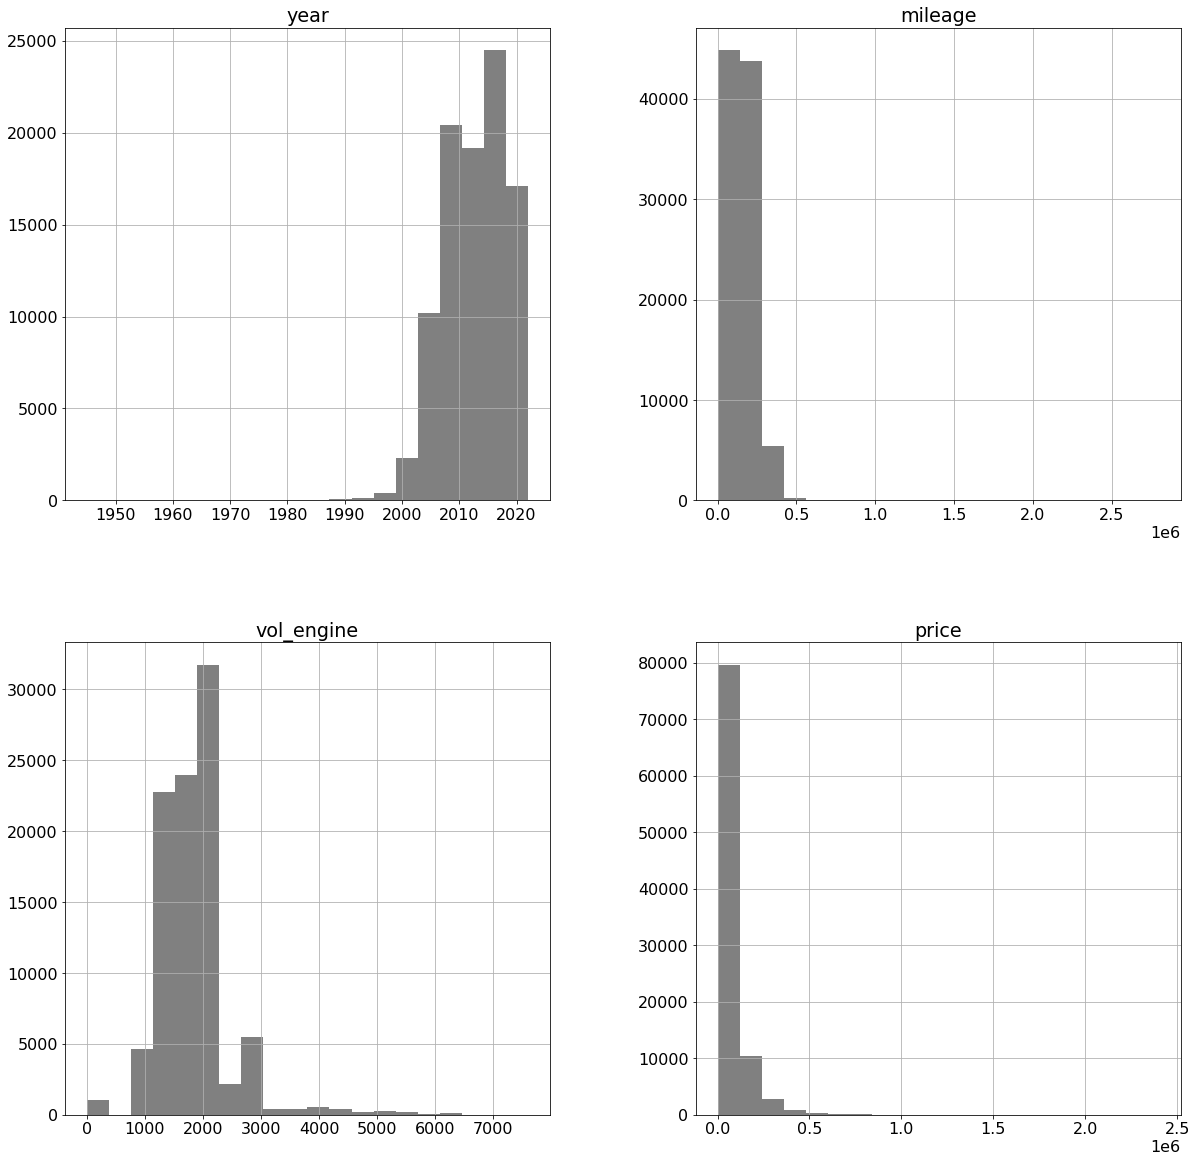

In [12]:
cars_train_val.hist(bins = 20, figsize=(20, 20), color="gray")
plt.show()

Widać na powyższych histogramach, że mamy do czynienia z wartościami, które w pojęciu statystycznym zostałyby uznane za wartości odstające, lecz mają one sens jeśli chodzi o samochody. Wiek samochodu koło 1950 jest jak najbardziej możliwy, podobnie z ceną bliską 2 mln złotych. Podobna sytuacja dotyczy przebiegu 2.5 mln mil. Jest to niezwykle dużo, ale należy pamiętać, że nie jest to wynik niemożliwy chociażby dla samochodów ciężarowych (rzadki ale możliwy), dlatego też nie będziemy usuwać tej obserwacji.

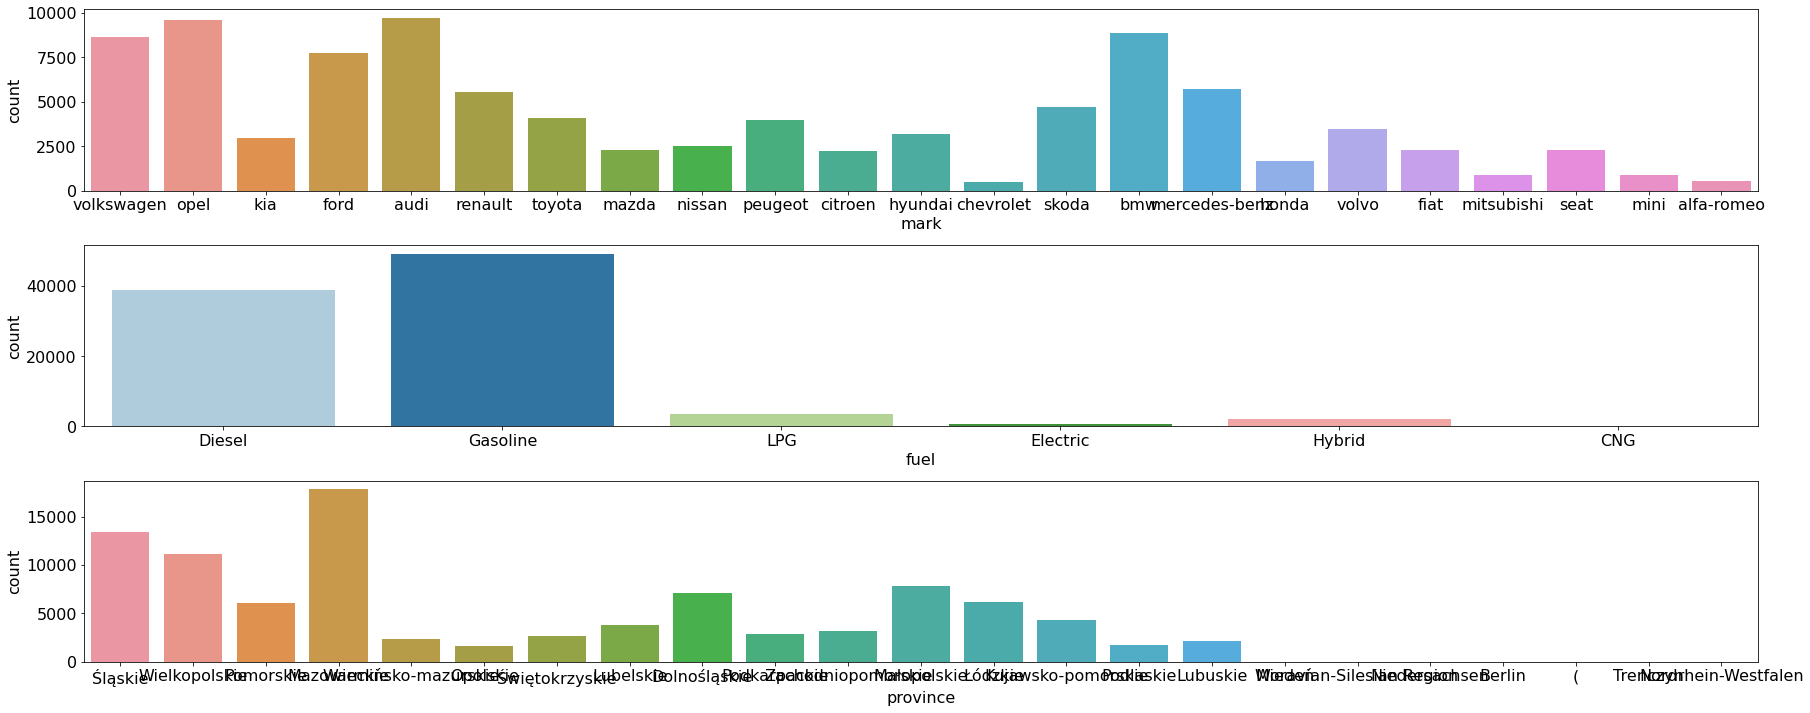

In [13]:
discrete_col_names = ["mark", "fuel", "province"]
fig, axes = plt.subplots(3, 1, figsize = (30, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.5)
sns.set_palette("Paired")

for col, ax in zip(discrete_col_names, axes.flatten()):
    sns.countplot(x=col, data=cars_train_val, ax=ax)

Nic ciekawego nie ma dla zmiennej `mark` oraz `fuel`. Dla zmiennej `province` widać że dla pewnych wartości jest bardzo mało wartości. Przyjżyjmy się jednak tym danym bliżej.

## Preprocessing

### Ujednolicanie wartości zmiennych 

In [14]:
cars_train_val["province"].value_counts()

Mazowieckie                 17832
Śląskie                     13404
Wielkopolskie               11145
Małopolskie                  7817
Dolnośląskie                 7117
Łódzkie                      6207
Pomorskie                    6106
Kujawsko-pomorskie           4312
Lubelskie                    3789
Zachodniopomorskie           3167
Podkarpackie                 2857
Świętokrzyskie               2689
Warmińsko-mazurskie          2312
Lubuskie                     2196
Podlaskie                    1703
Opolskie                     1655
Moravian-Silesian Region       26
Berlin                          2
Wiedeń                          1
Niedersachsen                   1
(                               1
Trenczyn                        1
Nordrhein-Westfalen             1
Name: province, dtype: int64

Można na pewno usunąć obserwację z regionem "(" a resztę, która nie jest polskimi wojewódźtwami zaminić na "Other".

In [15]:
provinces_to_keep = ["Mazowieckie", "Śląskie", "Wielkopolskie", "Małopolskie",
                     "Dolnośląskie", "Łódzkie", "Pomorskie", "Kujawsko-pomorskie",
                     "Lubelskie", "Zachodniopomorskie", "Podkarpackie", "Świętokrzyskie",
                     "Warmińsko-mazurskie", "Lubuskie", "Podlaskie", "Opolskie"]
cars_train_val.loc[~cars_train_val["province"].isin(provinces_to_keep), "province"] = "Other"

In [17]:
cars_train_val["city"].value_counts()

Warszawa                    6385
Łódź                        2619
Kraków                      2338
Wrocław                     2225
Poznań                      1895
                            ... 
Koziniec                       1
Kleszczewo                     1
Mlewiec                        1
Koninko                        1
Kolonia Wola Zaradzyńska       1
Name: city, Length: 4025, dtype: int64

In [18]:
tmp_df = (cars_train_val["city"].value_counts() <= 10)
cities_to_keep = list(tmp_df.loc[tmp_df==True].index)

In [19]:
cars_copy = cars_train_val.copy()
cars_copy.loc[cars_copy["city"].isin(cities_to_keep), "city"] = "Other"

In [20]:
cars_train_val.loc[cars_train_val["city"].isin(cities_to_keep), "city"] = "Other"

### Kodowanie wartości kolumn

In [23]:
col_names_encode = ["mark", "model", "fuel", "city", "province"]
encoded = pd.get_dummies(cars_train_val[col_names_encode].astype(str))
# encoded = encoded.drop(["Gender_Female","Customer Type_Loyal Customer", "Type of Travel_Business travel", "Class_Eco"], axis = 1)
cars_train_val = cars_train_val.drop(col_names_encode, axis=1)
cars_train_val = pd.concat([cars_train_val, encoded], axis = 1)

### Skalowanie zmiennych ciągłych

In [24]:
col_names = ["year", "mileage", "vol_engine"]

min_max_scaler = MinMaxScaler()

for col in col_names:
    scaled_col = min_max_scaler.fit_transform(cars_train_val[col].values.reshape(-1, 1))
    cars_train_val[col] = scaled_col

In [25]:
print(cars_train_val["price"].max())
print(cars_train_val["price"].min())
print(cars_train_val["price"].mean())
print(cars_train_val["price"].median())

2399900
500
70291.57060026923
41900.0


## Podział zbioru na część treningową oraz validacyjną

In [87]:
y = cars_train_val['price']
y = y.astype('int')
X = cars_train_val.drop("price", axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=420, test_size=0.125)

## Zabawa z klasyfikatorami

In [27]:
def show_model_metrics_regression(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f"Max error: {max_error(y_val, y_pred)}")
    print(f"Mean absolute error: {mean_absolute_error(y_val, y_pred)}")
    print(f"Median absolute error: {median_absolute_error(y_val, y_pred)}")
    print(f"RMSE: {mean_squared_error(y_val, y_pred, squared=False)}")
    print(f"R2 score: {r2_score(y_val, y_pred)}")

### RandomForestRegressor

Bazowe hiperparametry

Wyjątkiem tutaj sa random_state=2022 (użyte dla powtarzalności wyników) oraz n_jobs=-1 (w celu przyspieszenia obliczeń)

In [28]:
rf_reg = RandomForestRegressor(random_state=2022, n_jobs=-1)
rf_reg.fit(X_train, y_train)
show_model_metrics_regression(rf_reg, X_val, y_val)

Max error: 669692.0
Mean absolute error: 8278.390683352241
Median absolute error: 3506.5699999999997
RMSE: 18739.512936313087
R2 score: 0.9528905059693306


---

In [227]:
rf_reg1 = RandomForestRegressor(random_state=2022, n_jobs=-1, criterion="absolute_error")
rf_reg1.fit(X_train, y_train)
show_model_metrics_regression(rf_reg1, X_val, y_val)

In [ ]:
rf_reg2 = RandomForestRegressor(random_state=2022, n_jobs=-1, criterion="poisson")
rf_reg2.fit(X_train, y_train)
show_model_metrics_regression(rf_reg2, X_val, y_val)

Czas uczenia się przy wybranym `absolute_error` oraz `poisson` jako kryterium jest znacznie duży, na tyle duży z porównaniem ze `squared_error` (domyślna wartość), że nie wiadomo kiedy byłby koniec procesu uczenia.

---

In [30]:
rf_reg3 = RandomForestRegressor(random_state=2022, n_jobs=-1, n_estimators=50)
rf_reg3.fit(X_train, y_train)
show_model_metrics_regression(rf_reg3, X_val, y_val)

Max error: 657751.0
Mean absolute error: 8341.93497477191
Median absolute error: 3514.540000000001
RMSE: 18902.938308860274
R2 score: 0.9520652489587063


Zmineijszenie liczy estymatorów do 50 nieznacznie zmniejszyło predykcyjność, ale za to model się szybcie uczy.

---

In [32]:
rf_reg4 = RandomForestRegressor(random_state=2022, n_jobs=-1, n_estimators=15)
rf_reg4.fit(X_train, y_train)
show_model_metrics_regression(rf_reg4, X_val, y_val)

Max error: 667681.0
Mean absolute error: 8556.01144833567
Median absolute error: 3599.0
RMSE: 19314.25069194883
R2 score: 0.949956512207755


Co ciekawe tutaj predykcyjność też nie jest znacznie niższa, mimo że 15 estymatorów to znacznie mniej niż 100.

---

In [35]:
rf_reg5 = RandomForestRegressor(random_state=2022, n_jobs=-1, max_depth = 4)
rf_reg5.fit(X_train, y_train)
show_model_metrics_regression(rf_reg5, X_val, y_val)

Max error: 779242.917303694
Mean absolute error: 21138.730096584834
Median absolute error: 11058.808113483632
RMSE: 37701.58184643126
R2 score: 0.8093174343609323


In [36]:
rf_reg6 = RandomForestRegressor(random_state=2022, n_jobs=-1, max_depth = 8)
rf_reg6.fit(X_train, y_train)
show_model_metrics_regression(rf_reg6, X_val, y_val)

Max error: 699067.6613544743
Mean absolute error: 14742.663223181537
Median absolute error: 7564.445751820247
RMSE: 27225.665411998143
R2 score: 0.9005628088433542


Jak można zauważyć w dwóch powyższych przykładach zmiana maksymalnej głębokości drzewa już znacząco wpływa na predykcyjność. Dla tych konkretnych danych. może wynikać to z użycia kodowania OneHot, w wyniku którego powstało ponad 1000 nowych kolumn, co powoduje, że drzewa decyzyjne rozrastają się bardzo w głąb i wartość hiperparametru `max_depth` powinna być w tym przypadku dość duża, aby uzyskać satysfakcjonującą predykcyjność.

#### Wnioski odnośnie RandomForestRegression

Z powyższych przykładów można wysnąć wniosek, że dla naszych danych oraz dokonanego sposobu kodowania zmiennych hiperparametr `max_depth` ma znaczącą wartość na predykcyjność, natomiast `n_estimators` już niekoniecznie.

### XGBoost

In [37]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False)
xgb_reg.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg, X_val, y_val)

Max error: 662683.8125
Mean absolute error: 10514.204811160238
Median absolute error: 5207.375
RMSE: 21259.535676766467
R2 score: 0.9393683492932579


In [38]:
xgb_reg1 = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False, max_depth=4)
xgb_reg1.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg1, X_val, y_val)

Max error: 678631.0625
Mean absolute error: 12058.48442124346
Median absolute error: 6144.7509765625
RMSE: 23057.43233712537
R2 score: 0.928679606960069


Ustawienie `max_depth` na wartość 4 zmniejsza nieznacznie predykcyjność.

In [39]:
xgb_reg2 = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False, max_depth=15)
xgb_reg2.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg2, X_val, y_val)

Max error: 655578.125
Mean absolute error: 8376.603717657423
Median absolute error: 3686.09375
RMSE: 19111.697267079813
R2 score: 0.951000645691727


Ustawienie `max_depth` na wartość 15 zwiększa trochę predykcyjność, co jest miłym zaskoczeniem.

In [89]:
xgb_reg2 = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False, max_depth=30)
xgb_reg2.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg2, X_val, y_val)

Max error: 646706.875
Mean absolute error: 8506.169562009276
Median absolute error: 3499.9609375
RMSE: 20169.652630066903
R2 score: 0.945425636465967


Z porównaniem do `max_depth` ustawionym na 15, przy wartości 30 jedynie wartości błędów względnych są lepsz, jednakże porównując RMSE oraz R2 score widać już spadek predykcyjności, jednakże i tak są to lepsze wartości od tych, które zostały uzyskane przy domyślnie ustawionych parametrach.

---

In [41]:
xgb_reg3 = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False, n_estimators=10)
xgb_reg3.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg3, X_val, y_val)

Max error: 713864.3125
Mean absolute error: 13976.920903820062
Median absolute error: 7186.390625
RMSE: 26395.745158432233
R2 score: 0.9065327003678243


Ustawienei hiperparametru `n_estimators` na wartość 10 zmniejsza predykcyjność.

In [42]:
xgb_reg4 = xgb.XGBRegressor(objective="reg:squarederror", seed = 2022, use_label_encoder=False, n_estimators=50)
xgb_reg4.fit(X_train, y_train)
show_model_metrics_regression(xgb_reg4, X_val, y_val)

Max error: 667753.125
Mean absolute error: 11694.828497659662
Median absolute error: 5936.484375
RMSE: 22813.46460262589
R2 score: 0.9301808861605523


Natomiast przy zmianie `n_estimators` na wartość 50 zmiana predykcyjności względem dobyślnych parametrów estymatora nie jest znacząca.

#### Wnioski odnośnie XGBRegressor

Z powyższych przykładów widać że predykcyjność modelu zmienia się wraz ze zmianą hiperparamatrów zarówno na lesza jak i na gorsze.

### Porównanie RandomForestRegressor z XGBRegressor

Różnica miedzy dwoma modelami jak taka, że RandomForestRegressor jest bardziej wrażliwy na zmianę parametru `max_depth`, natomiast XGBRegresson jest wrażliwszy na zmiany `n_estimators`.